# Creación del Modelo de Red Neuronal Convolucional para la Detección de Artritis de Rodilla

## Propósito
El propósito de este notebook es desarrollar un modelo de red neuronal convolucional (CNN) para la detección y clasificación de la artritis de rodilla utilizando el dataset "Annotated Dataset for Knee Arthritis Detection". Este modelo ayudará a mejorar la precisión y consistencia en el diagnóstico de la artritis.

## Metodología
La creación del modelo se ha estructurado en una serie de pasos clave para asegurar su eficacia y precisión:

1. **Preprocesamiento de Datos y Aumento de Datos:**

    Estos pasos se realizaron previamente para asegurar la calidad y variedad del conjunto de datos. Se eliminaron imágenes duplicadas, se separaron las que mostraban dos rodillas, se normalizaron los valores de píxeles, se convirtieron a escala de grises y se redimensionaron uniformemente. Además, se aplicaron técnicas de aumento de datos para incrementar la diversidad del conjunto de entrenamiento. Las imágenes utilizadas en este notebook ya están preprocesadas y aumentadas.

2. **Construcción del Modelo:**

    * **Importación del Modelo Preentrenado:** Se utiliza DenseNet y ResNet como base del modelo, excluyendo su capa superior.
    * **Diseño de la Arquitectura:** Definición de las capas adicionales sobre la base del modelo preentrenado.

3. **Compilación del Modelo:**

    * Definición del optimizador, función de pérdida y métricas de evaluación.

4. **Entrenamiento del Modelo:**

    * Configuración del callback para guardar el mejor modelo basado en la precisión de validación.
    * Entrenamiento del modelo con los datos preprocesados.

5. **Verificación de Resultados:**
    * Evaluación de las métricas de rendimiento del modelo, incluyendo exactitud (accuracy), precisión (precision), recuperación (recall) y pérdida (loss).

## Resultados Esperados
Se espera desarrollar un modelo de red neuronal convolucional que pueda clasificar con precisión las imágenes de radiografías de rodilla en las diferentes etapas de la artritis. Los resultados del modelo proporcionarán una herramienta valiosa para los médicos, mejorando la consistencia y precisión en el diagnóstico de la artritis y potencialmente automatizando el proceso en el futuro.

A continuación, se presentan los detalles y resultados de cada uno de los pasos realizados.

## Paso 1: Preprocesamiento de Datos y Aumento de Datos

In [31]:
from utils import load_dataset_tensorflow,plot_accuraccy_loss,plot_accuraccy,plot_precision,plot_recall,plot_loss,plot_confusion_matrix
import tensorflow as tf
import os

In [32]:
train_ds, valid_ds = load_dataset_tensorflow(os.path.join("data","processed","images"),subset="both",validation_split=0.2)

Found 2542 files belonging to 5 classes.
Using 2034 files for training.
Using 508 files for validation.


In [33]:
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale image to RGB
    return image, label

train_ds = train_ds.map(convert_to_rgb)
valid_ds = valid_ds.map(convert_to_rgb)

In [34]:
valid_labels = []

for _, labels in valid_ds:
    valid_labels.extend(labels.numpy())

2024-07-14 04:30:17.007585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Paso 2: Construcción del Modelo
* **Importación del Modelo Preentrenado:** Se utiliza DenseNet y ResNet como base del modelo, excluyendo su capa superior.

In [35]:
from tensorflow.keras.applications import DenseNet121, ResNet152V2

base_model_denseNet = DenseNet121(include_top=False)
base_model_denseNet.trainable = False
for layer in base_model_denseNet.layers[-20:]:
    layer.trainable = True

base_model_renseNet = ResNet152V2(include_top=False)
base_model_denseNet.trainable = False
for layer in base_model_renseNet.layers[-20:]:
    layer.trainable = True

*  **Diseño de la Arquitectura: Definición de las capas adicionales sobre la base del modelo preentrenado.**

In [36]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
import tensorflow as tf

def build_model(model_base, input_shape):
    inputs = Input(shape=input_shape)
    x = model_base(inputs, training=False)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model_denseNet = build_model(base_model_denseNet, (256,256,3))
model_renseNet = build_model(base_model_renseNet, (256,256,3))

## Paso 3: Compilación del modelo

* Definición del optimizador, función de pérdida y métricas de evaluación.

In [37]:
model_denseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model_renseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [38]:
model_denseNet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │     2,097,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,134,853 (34.85 MB)

 Trainable params: 2,464,517 (9.40 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

In [39]:
model_renseNet.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 8, 8, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │     4,194,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,526,149 (238.52 MB)

 Trainable params: 62,382,405 (237.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

## Paso 4: Entrenamiento del Modelo:

* Configuración del callback para guardar el mejor modelo basado en la precisión de validación.

In [40]:
check_callback_denseNet = tf.keras.callbacks.ModelCheckpoint("models/callbacks/{epoch:02d}-{val_accuracy:.2f}-DenseNet121.keras", verbose=0, save_best_only=True, monitor='val_accuracy')
check_callback_renseNet = tf.keras.callbacks.ModelCheckpoint("models/callbacks/{epoch:02d}-{val_accuracy:.2f}-ResNet152V2.keras", verbose=0, save_best_only=True, monitor='val_accuracy')

* Entrenamiento del modelo con los datos preprocesados y aumentados.

In [41]:
history_denseNet = model_denseNet.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[check_callback_denseNet])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.2171 - loss: 4.8940 - precision: 0.2442 - recall: 0.0744 - val_accuracy: 0.2185 - val_loss: 1.6093 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.1991 - loss: 1.6095 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2067 - val_loss: 1.6096 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.2092 - loss: 1.6092 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2067 - val_loss: 1.6098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.2174 - loss: 1.6089 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2067 - val_loss: 1.6100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.2228 - loss: 1.6086 - precision: 0.000

In [ ]:
history_renseNet = model_renseNet.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[check_callback_renseNet])

## Paso 5: Verificación de Resultados

* Evaluación de las métricas de rendimiento del modelo, incluyendo exactitud (accuracy), precisión (precision), recuperación (recall) y pérdida (loss).

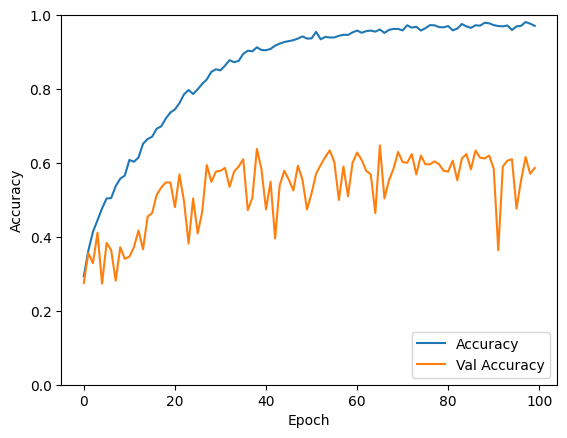

In [20]:
plot_accuraccy(history_denseNet)
plot_precision(history_denseNet)
plot_recall(history_denseNet)
plot_loss(history_denseNet)

In [ ]:
plot_accuraccy(history_renseNet)
plot_precision(history_renseNet)
plot_recall(history_renseNet)
plot_loss(history_renseNet)

* Generación de la matriz de confusión para analizar el desempeño del modelo en cada clase.

In [24]:
from sklearn.metrics import confusion_matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


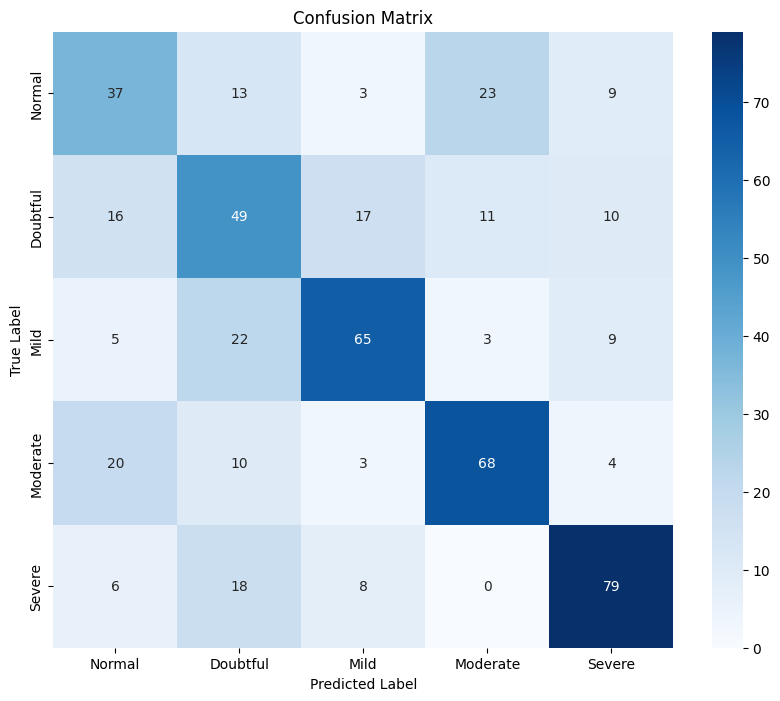

In [25]:
y_pred_prob = model_denseNet.predict(valid_ds)
y_pred = tf.argmax(y_pred_prob, axis=1)
y_true = tf.argmax(valid_labels, axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

plot_confusion_matrix(cm, class_names)

In [ ]:
y_pred_prob = model_renseNet.predict(valid_ds)
y_pred = tf.argmax(y_pred_prob, axis=1)
y_true = tf.argmax(valid_labels, axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

plot_confusion_matrix(cm, class_names)